In [1]:
import torch
from repop import dataset,params2theta,theta2params
import pandas as pd
from matplotlib import pyplot as plt


In [2]:
def load_dataset(filename,Nmax=10**10,remove_zeros=True,threshold=300):
    df=pd.read_csv(filename)[:Nmax]
    cts,dils = df['Counts'].to_numpy(),df['Dilution'].to_numpy().astype(float)
    if remove_zeros:
        cts,dils = cts[cts!=0],dils[cts!=0]
    return dataset(cts,dils,threshold)

In [3]:
data = load_dataset('synth_data/synth_unimodal.csv',Nmax=1000,threshold=-1)
th_gt = params2theta(*torch.tensor((8000,500,1.)))

In [4]:
data.evaluate(components=1)

1
3.4021457417234657 -3390.112296063092 -9.896599442907789
3.334660148931693 -3323.9879873041546 -10.588367313353345
3.331390825408769 -3320.507569590327 -10.873522927262302
3.3309314670567005 -3319.921542859973 -11.00821028764003


(tensor([7943.5609], device='cuda:0', dtype=torch.float64),
 tensor([529.6512], device='cuda:0', dtype=torch.float64),
 tensor([1.], device='cuda:0', dtype=torch.float64))

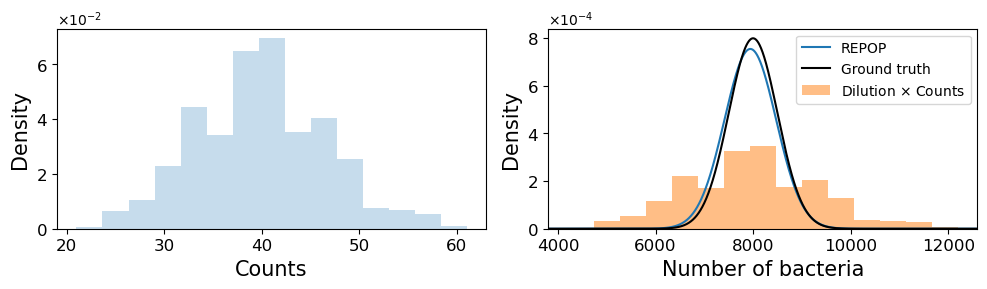

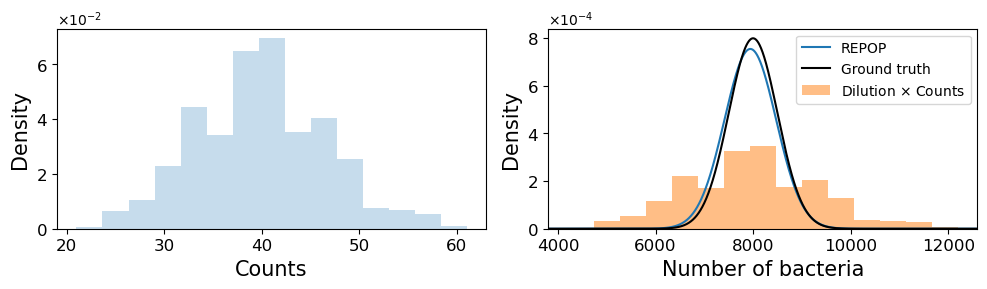

In [5]:
data.make_plot('graphs/synth/unimodal.png',th_gt)

In [6]:
del data.lpkdil_n
del data

In [7]:
data2 = load_dataset('synth_data/synth_multimodal_harder.csv',Nmax=1000,threshold=-1)
th_gt = params2theta(*torch.tensor(((4000,8000,14000),
                                   (200,1500,1000),
                                   (.25,.4,.35))))


In [8]:
data2.loglike(th_gt.to(data2.device),th_gt.size(0)//3).sum()

tensor(-4346.6662, device='cuda:0', dtype=torch.float64)

In [9]:
data2.evaluate()

25
4.704614825707855 -4351.927860272939 -348.8914172821501
4.60590020257866 -4346.452655442961 -258.9799328835649
4.555842045876204 -4348.541543415679 -206.93904049201728
4.529078031455812 -4348.4680747349175 -180.4215220054033
4.514426109872406 -4348.415010194887 -165.89892138178334
4.5051456024243155 -4348.427601422511 -156.6464719471581
4.498989711744396 -4348.4990281634755 -150.44574361418535
4.495671920978472 -4348.534900884864 -147.11561181806024


(tensor([14060.1101, 14043.8330,  3976.4995,  7980.8541,  3985.8905,  7957.0328,
          7933.5229, 13676.8580,  7813.9879, 11356.2269,  7621.0655, 10547.8990,
         10353.7258,  4037.3494,  4039.6147,  6778.4808,  4028.8855,  4009.5424,
          3977.1634,  3934.6682,  4962.4976,  4992.3172,  4865.7040],
        device='cuda:0', dtype=torch.float64),
 tensor([ 899.9300,  958.0047,  378.7270,  887.4596,  415.6738, 1025.4141,
         1121.6794, 1799.2766, 1433.9944, 2885.6247, 1647.3578, 2880.5610,
         2879.8385,  650.9306,  685.7030, 1749.8874,  757.5911,  792.3606,
          824.6554,  856.9529, 1414.1989, 1481.9975, 1498.0753],
        device='cuda:0', dtype=torch.float64),
 tensor([0.1311, 0.1169, 0.0888, 0.0853, 0.0706, 0.0675, 0.0598, 0.0562, 0.0467,
         0.0422, 0.0364, 0.0329, 0.0291, 0.0236, 0.0206, 0.0191, 0.0157, 0.0136,
         0.0117, 0.0100, 0.0087, 0.0074, 0.0062], device='cuda:0',
        dtype=torch.float64))

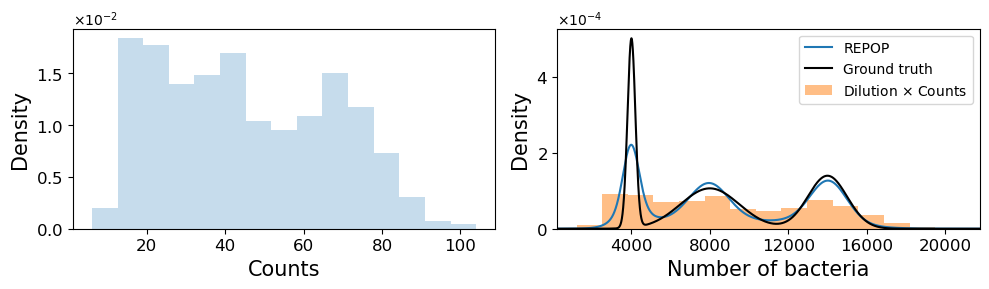

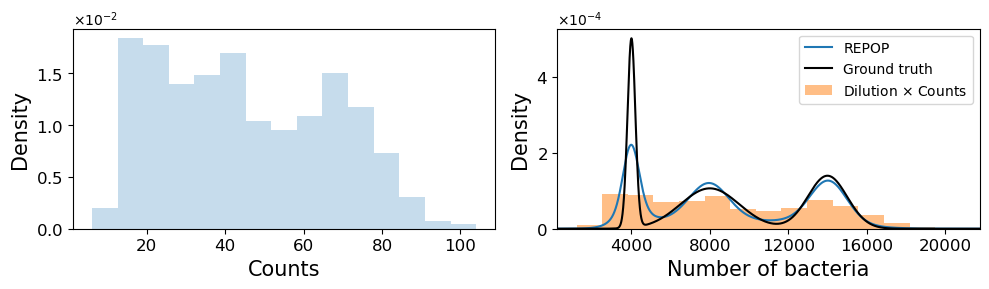

In [10]:
data2.make_plot('graphs/synth/multimodal_harder.png'.format(th_gt.numpy()),th_gt)

In [11]:
del data2.lpkdil_n
del data2